# Hyper-parameter Tuning and Configuration of ClaSP
By design, the ClaSP algorithm is parameter-free and learns its model-parameters from the data at hand. However, factors such as noise, complexity or ambiguity of a time series can deteriorate the learned design choices. Also, there are certainly scenarios, where you as a user have domain knowledge that you want (and should!) provide to ClaSP to improve its segmentation. Therefore, we implemented the algorithm to be fully configurable to user choices. In this notebook, we elaborate common options you may want to control.

In [79]:
import matplotlib.pyplot as plt
import numpy as np

from claspy.data_loader import load_tssb_dataset
from claspy.segmentation import BinaryClaSPSegmentation

In the ClaSPy package, we provide access to the <a href="https://github.com/ermshaua/time-series-segmentation-benchmark" target="_blank">"Time Series Segmentation Benchmark"</a> (TSSB) via a data loader. We first load the annoatated benchmark as a pandas DataFrame to use examples from it for illustration. Although as a user, you typically do not have annotated time series to compare the quality of segmentations, you can always investigate the amount, location and associated classification scores (higher is better!) of predicted change points as well as the ClaSP profile shape. Pronounced local maxima indicate high quality of computation.

In [80]:
df = load_tssb_dataset()
df

,dataset,window_size,cps,time_series
0,Adiac,10,"[572, 1012, 1232]","[1.681146, 1.383394, 1.029389, 0.688386, 0.354..."
1,ArrowHead,10,[753],"[-1.957721, -1.858082, -1.657983, -1.420794, -..."
2,Beef,50,[705],"[-0.380818, -0.352238, -0.295392, -0.225041, -..."
3,BeetleFly,10,[1280],"[1.114805, 0.774403, 0.477129, 0.115781, -0.24..."
4,BirdChicken,20,[1280],"[1.697714, 1.439032, 1.22287, 0.99708, 0.76479..."
...,...,...,...,...
70,UWaveGestureLibraryX,10,"[600, 1131, 1652, 2193]","[-0.889766, 0.722005, 0.869297, -0.553167, -0...."
71,UWaveGestureLibraryY,10,"[600, 1131, 1652, 2193]","[-1.523467, -0.106794, 0.190361, 0.979247, 0.3..."
72,UWaveGestureLibraryZ,10,"[600, 1131, 1652, 2193]","[-0.527058, 0.416111, -0.524027, 0.41141, 0.12..."
73,WordSynonyms,10,"[202, 2227]","[-1.183581, -0.514028, -0.480539, -0.394855, -..."


## Setting the Number of Segments
The ClaSP algorithm infers the amount of segments by applying a significance test to check that a potential change point is actually valid. The p-value for this check is robust, but could be changed with the `threshold` parameter. In cases, where only few data is available (<1k data points), it is recommended to just use a classification score threshold (`validation="score_threshold", threshold=.75`) to make the check. If you know the amount of segments you want to extract, you can simply set the `n_segments` parameter and disbale validation with `validation=None`.

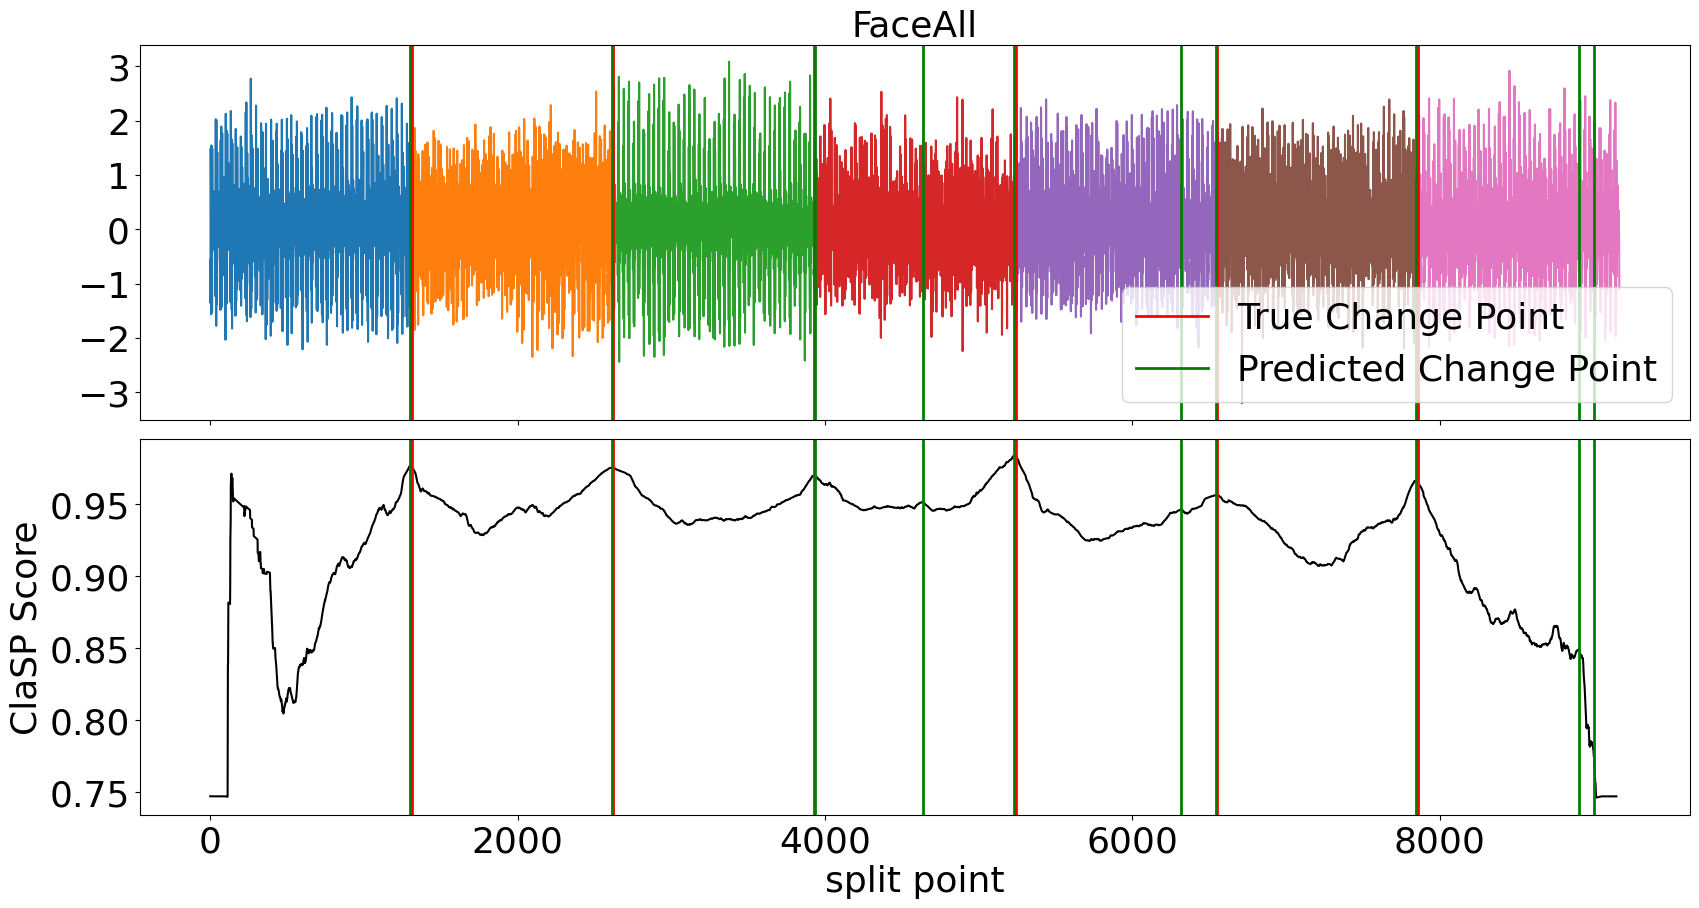

In [81]:
row = df.iloc[24, :]
clasp = BinaryClaSPSegmentation().fit(row.time_series)
clasp.plot(heading=row.dataset, gt_cps=row.cps)
plt.show()

Using domain knwoledge of the process this TS captures, we simply set `n_segments=7`, disable hypothesis testing with `validation=None` and can improve the results.

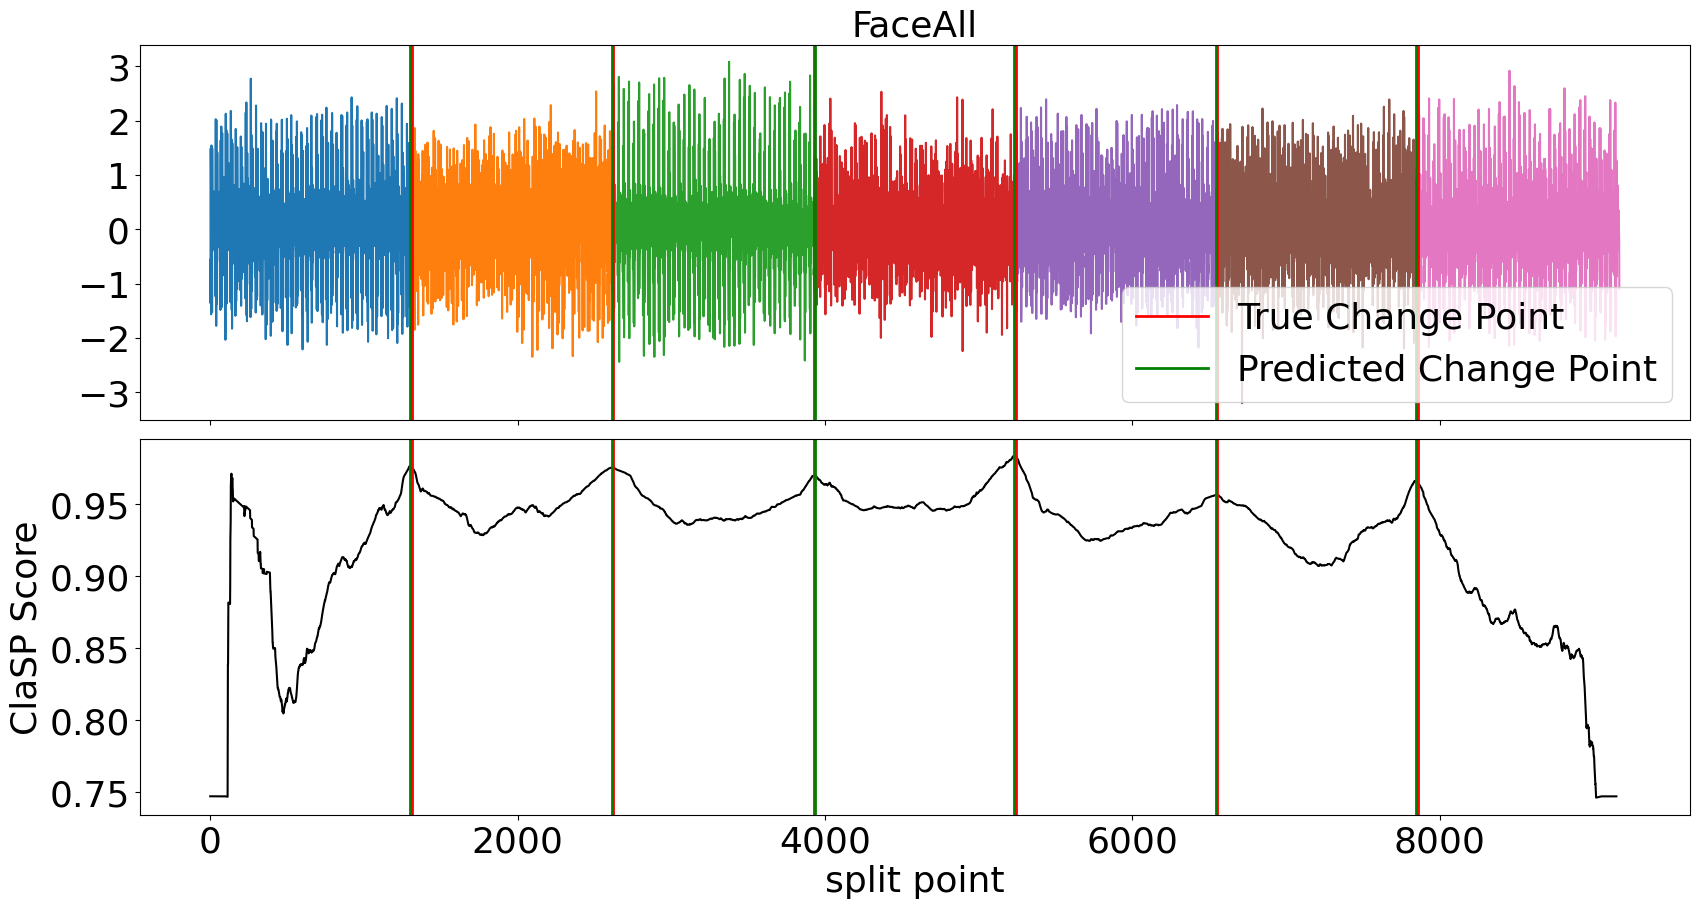

In [82]:
row = df.iloc[24, :]
clasp = BinaryClaSPSegmentation(n_segments=7, validation=None).fit(row.time_series)
clasp.plot(heading=row.dataset, gt_cps=row.cps)
plt.show()

## Window Size Selection
By default, ClaSP learns its window size with the SuSS (Summary Statistics Window Size) method, implemented in `claspy.window_size.suss`. Other options include the most dominant Fourier frequency `fft` or the highest autocorrelation `acf`. These should be tested, as they implement different notions of window sizes and one of them often fits your desired use case. If not, simply set your own desired value, using e.g. `window_size=10`. Conceptually, the window size in ClaSP should correspond to the length of a temporal pattern (cycle or period) that the classifier can differentiate.

Using window size: 16


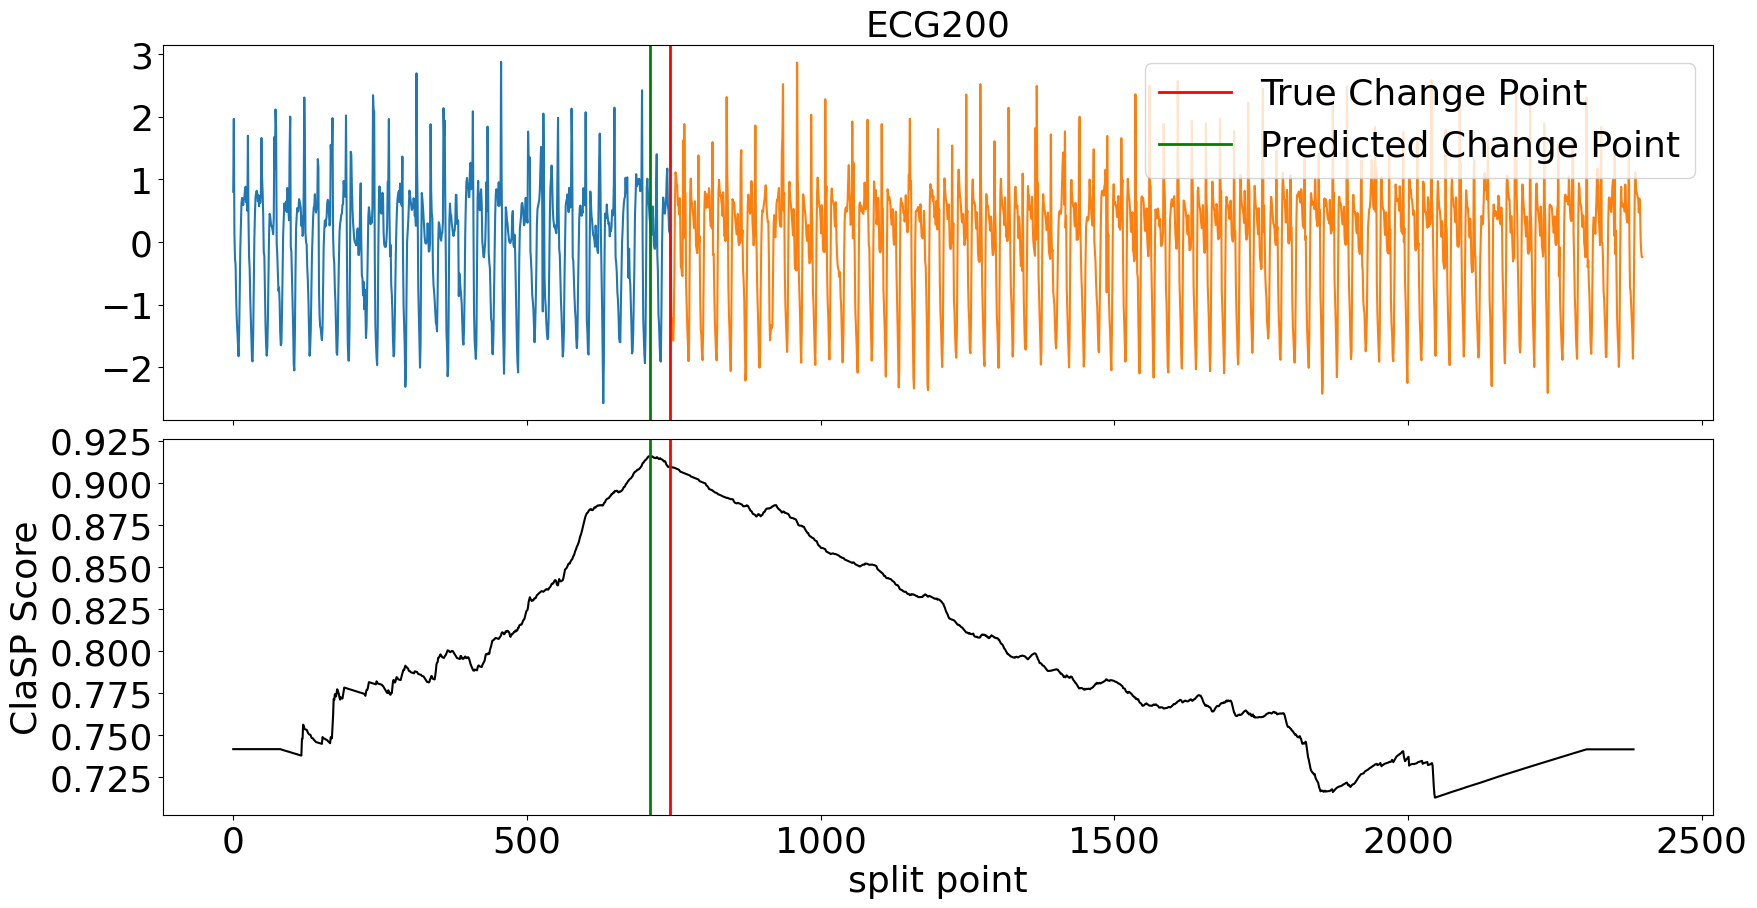

In [83]:
row = df.iloc[20, :]
clasp = BinaryClaSPSegmentation().fit(row.time_series)
clasp.plot(heading=row.dataset, gt_cps=row.cps)
print(f"Using window size: {clasp.window_size}")
plt.show()

In this example, besides `suss` we test `fft` and `acf` and find that the latter actually improves the segmentation accuracy.

Using window size: 24


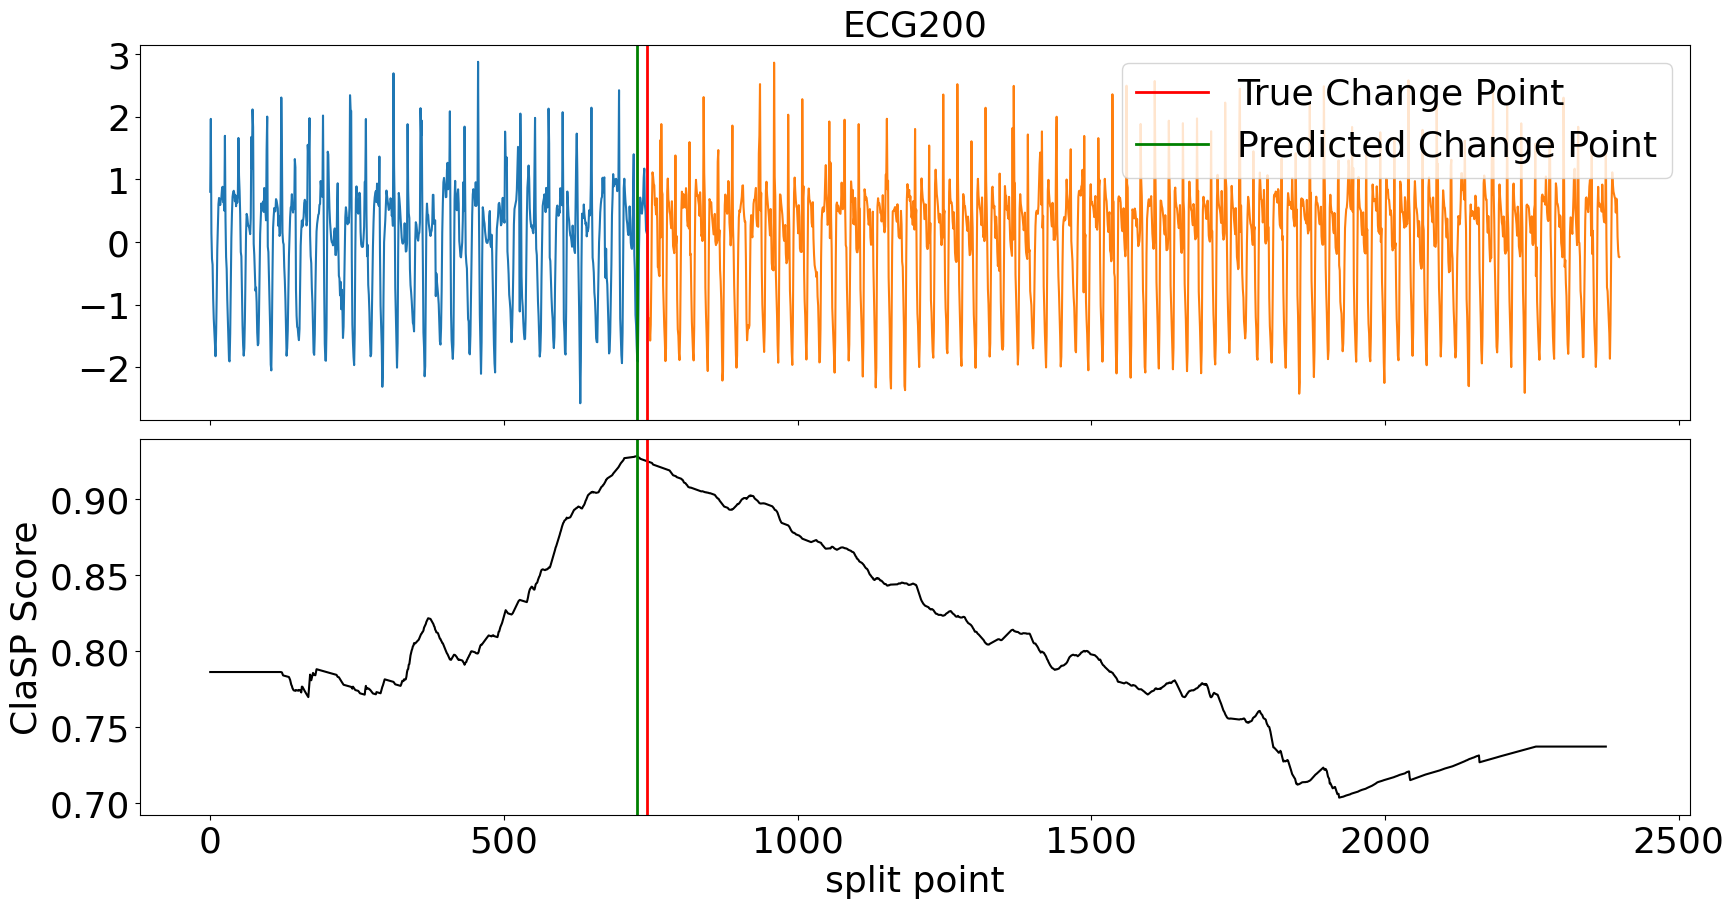

In [84]:
clasp = BinaryClaSPSegmentation(window_size="acf").fit(row.time_series)
clasp.plot(heading=row.dataset, gt_cps=row.cps)
print(f"Using window size: {clasp.window_size}")
plt.show()

## Choosing a Distance Measure
The ClasP method uses a k-NN classifier to differentiate segments. To compute the k-NN, we use `k=3`, which is robust, and calculate the z-normalized Euclidean distance between subsequences. This measure quantifies the difference of the shapes which is appropiate for many signals. For some, however, the shape is not primarily interesting, but more so the actual values of subsequences. In this case, you should use the regular Euclidean distance by setting `distance="euclidean_distance"`.

In [85]:
np.random.seed(1379)
dataset = "Noise"
cps = np.array([400, 1600, 1000])
time_series = np.concatenate((
    np.random.rand(cps[0]),
    1 + np.random.rand(cps[1]),
    -1 + np.random.rand(cps[2])
))
cps = np.cumsum(cps)[:-1]

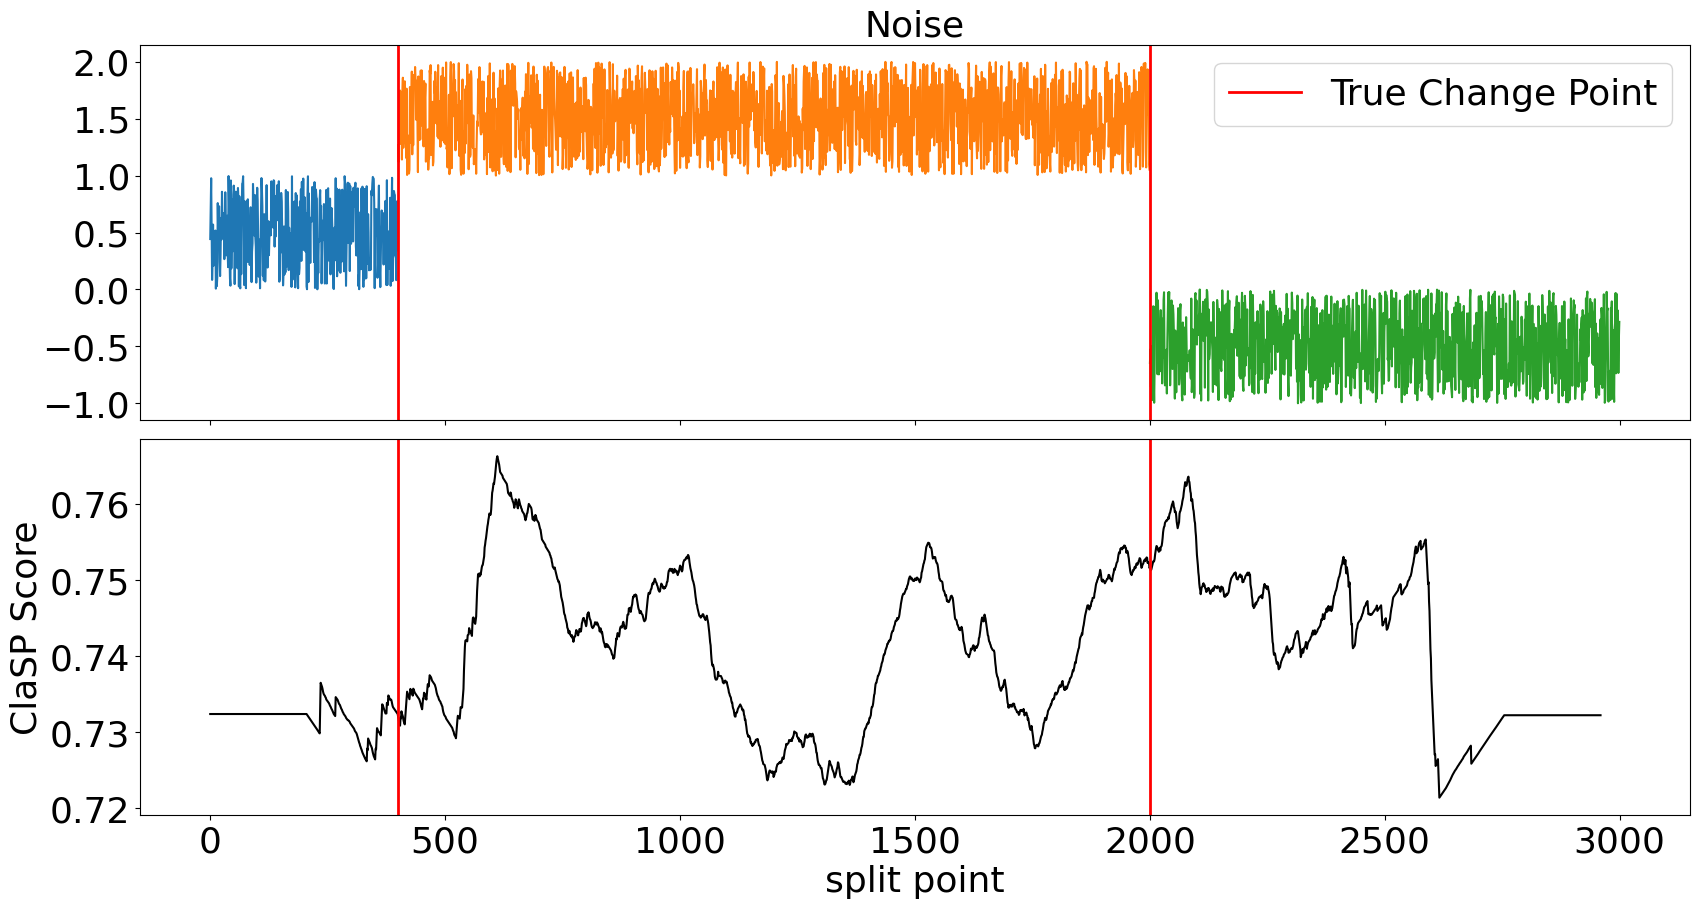

In [86]:
clasp = BinaryClaSPSegmentation().fit(time_series)
clasp.plot(heading=dataset, gt_cps=cps)
plt.show()

Looking at the time series, we observe that the segments do not differ in shape, but in the actual value ranges. Hence, we use the normal Euclidean distance and get a valid segmentation.

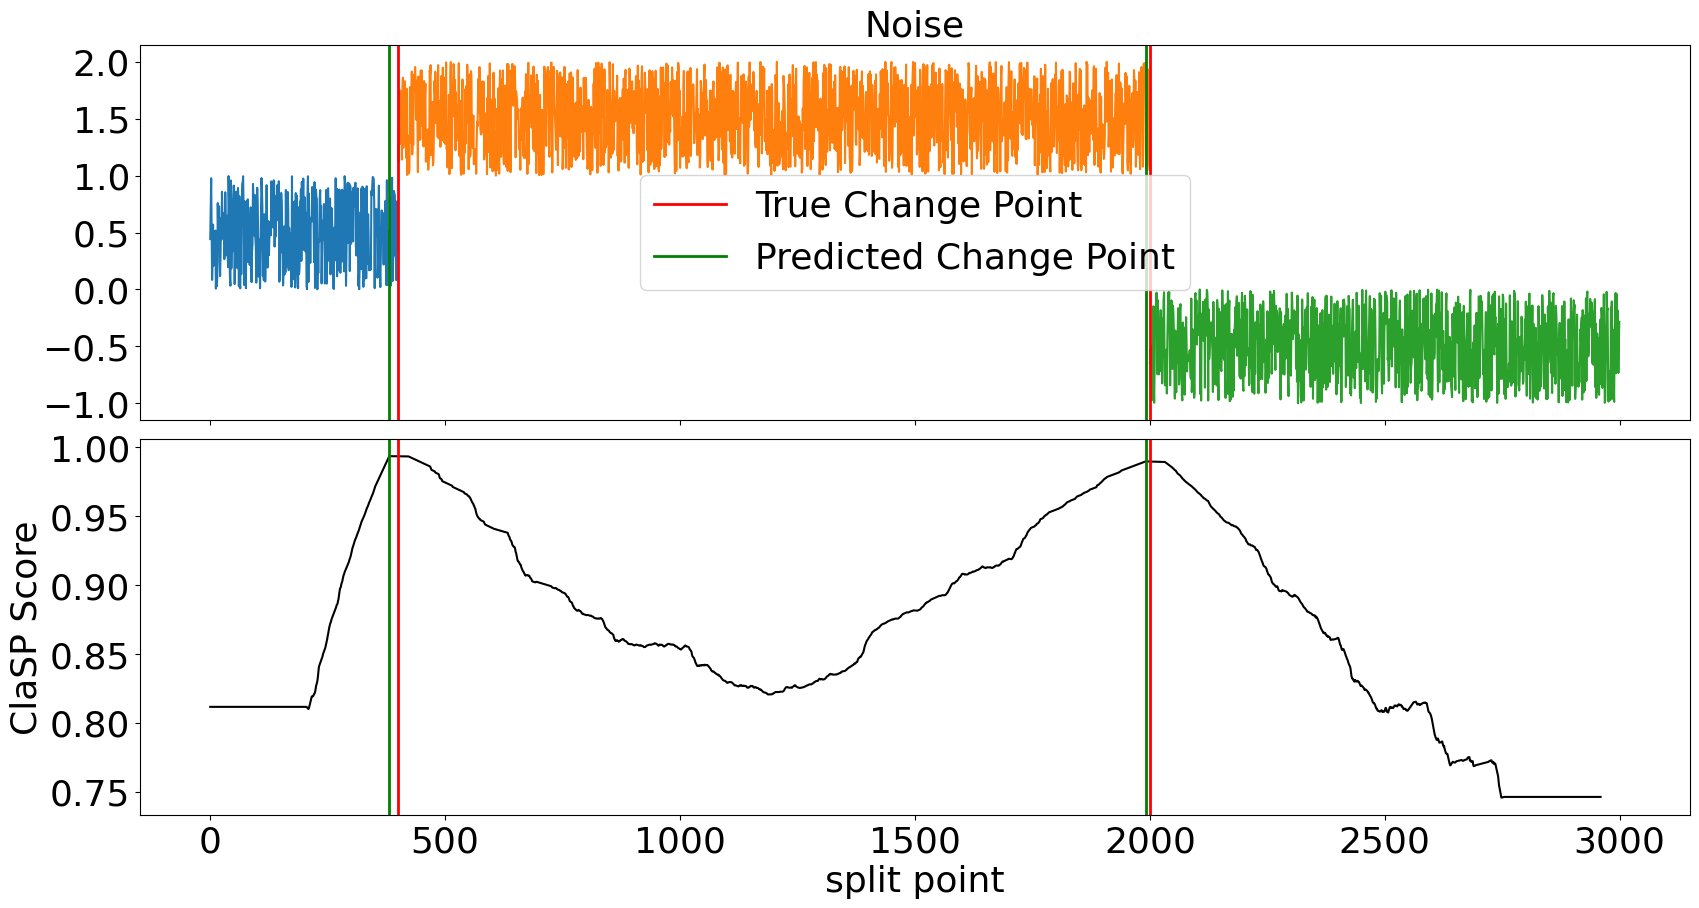

In [87]:
clasp = BinaryClaSPSegmentation(distance="euclidean_distance").fit(time_series)
clasp.plot(heading=dataset, gt_cps=cps)
plt.show()

## Minimum Segment Size Selection
ClaSP defines an exclusion radius around a found CP, with which the resolution of the segmentation can be guided. By default, `excl_radius=5` sets the minimum segment size to `5*window_size` and follows the rationale that a segment should at least have 5 instances of a temporal pattern to be considered meaningful. If you know that your segments are a lot larger than that, you can for example set `excl_radius=10` or even higher.

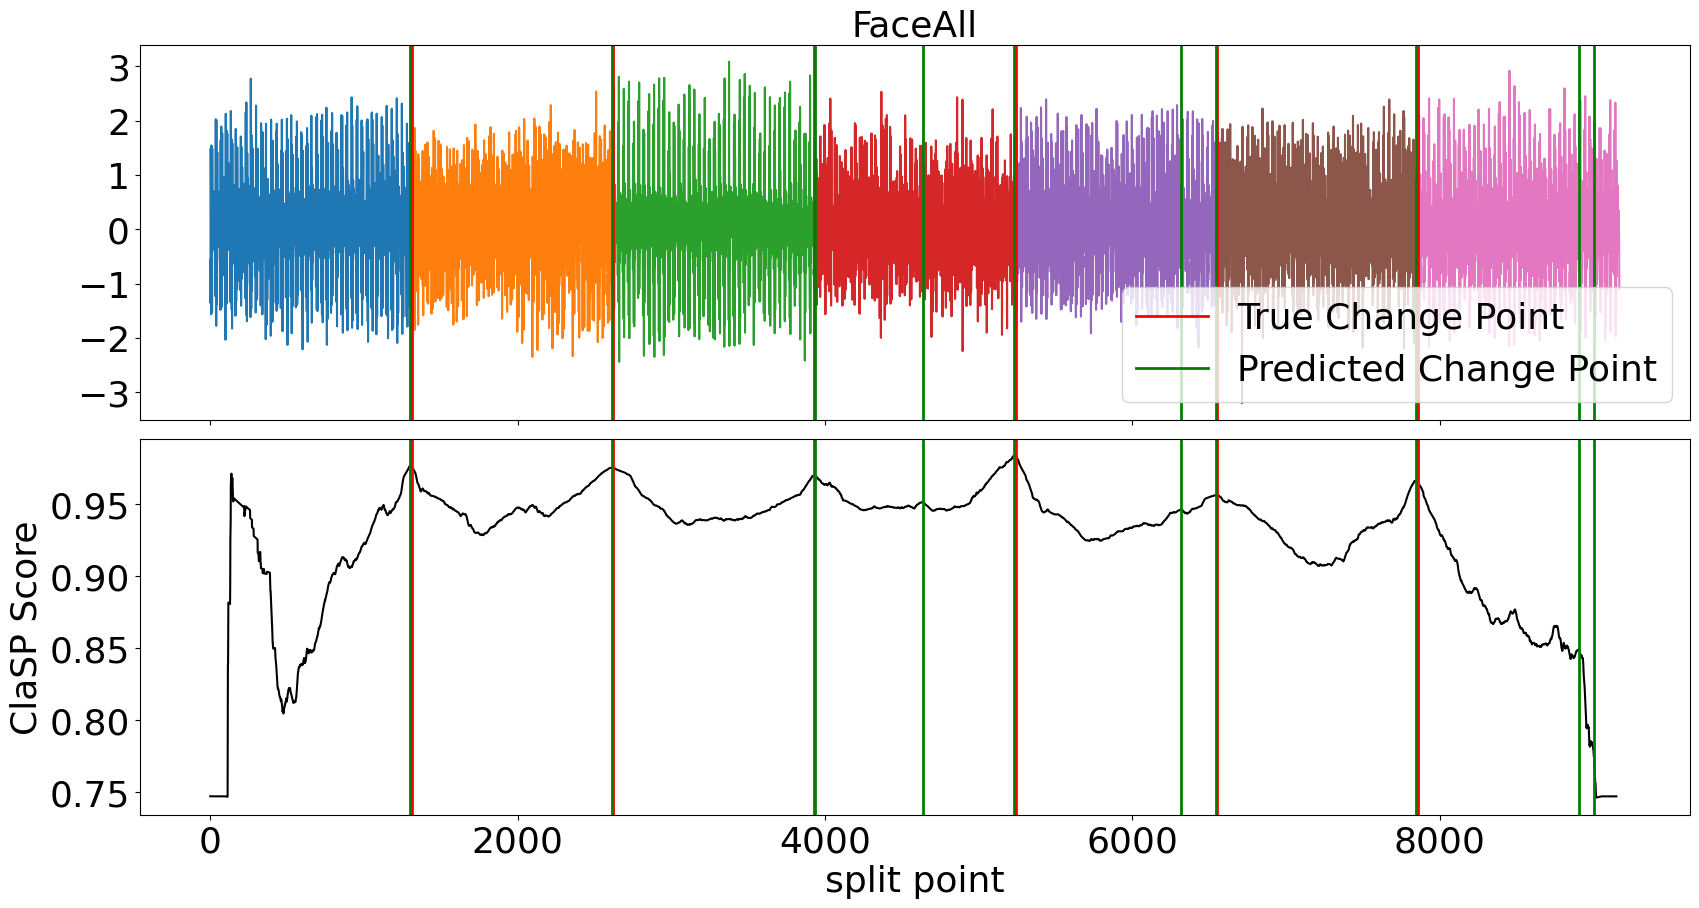

In [90]:
row = df.iloc[24, :]
clasp = BinaryClaSPSegmentation().fit(row.time_series)
clasp.plot(heading=row.dataset, gt_cps=row.cps)
plt.show()

Knowing that our time series contains many instances of temporal patterns, we set `excl_radius=50` and improve results.

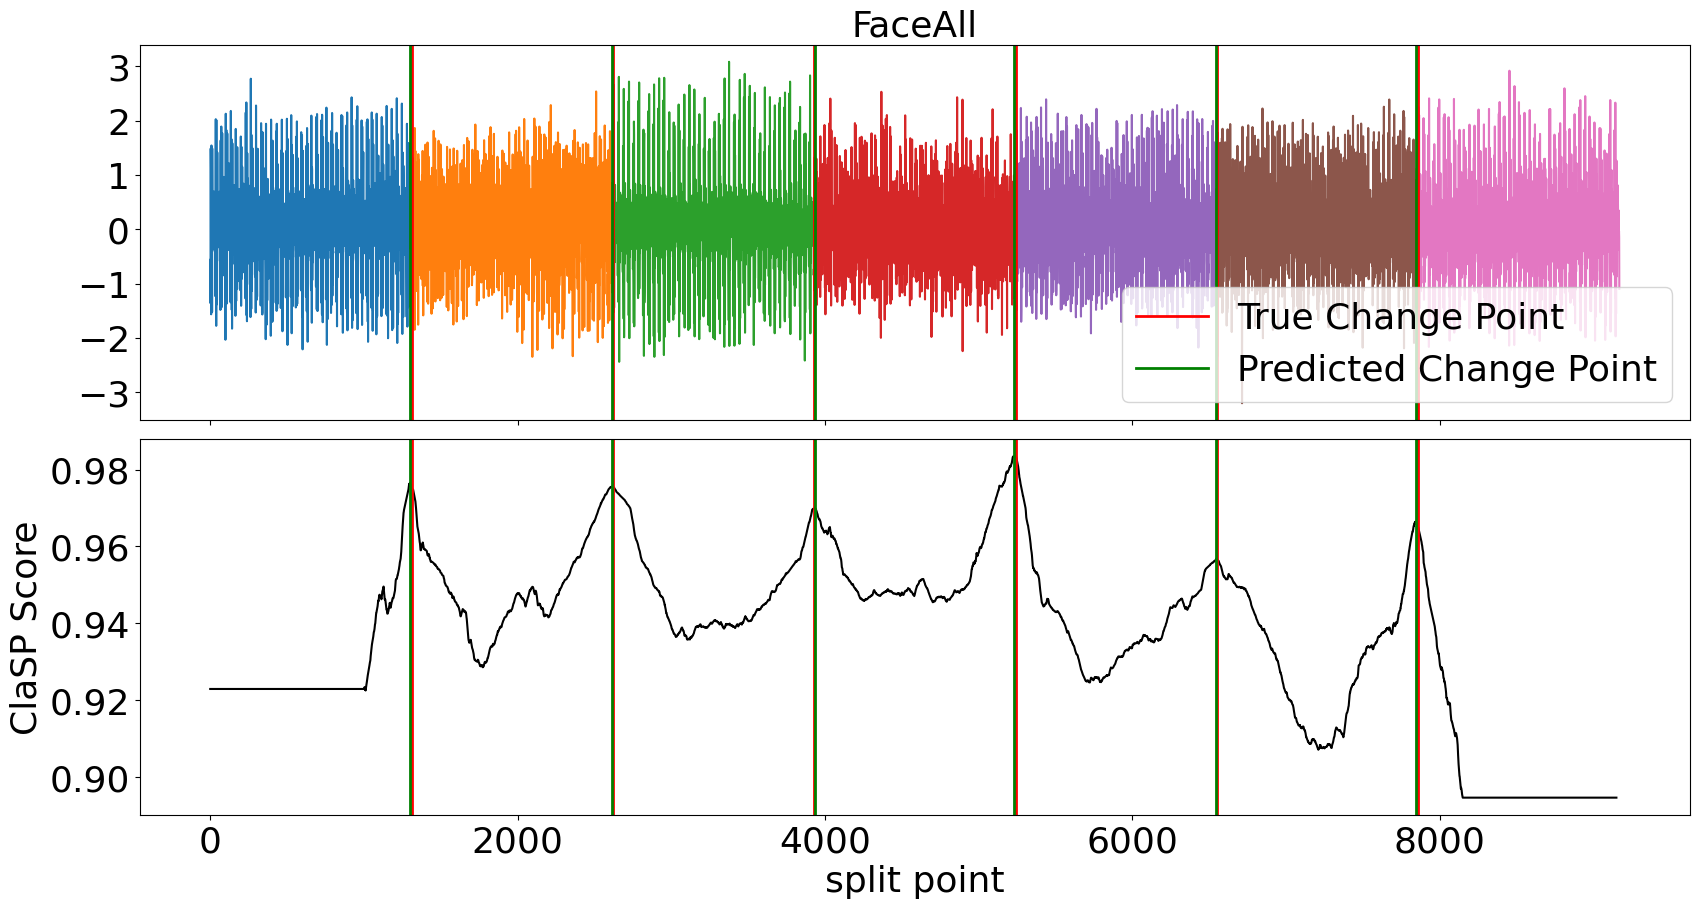

In [91]:
clasp = BinaryClaSPSegmentation(excl_radius=50).fit(row.time_series)
clasp.plot(heading=row.dataset, gt_cps=row.cps)
plt.show()

This concludes the configuration of ClaSP. The number of segments, window size, distance measure and minimum segment size largely influence the resulting segmentation and should be tuned to improve results or enforce certain guidelines.